In [1]:
# import important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0,'../scripts/')
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv("../data/AdSmartABdata.csv")
df_control= pd.read_csv("../data/control_group_data.csv")
df_exposed= pd.read_csv("../data/exposed_clean_data.csv")

In [5]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [6]:
# Dropping observations where there was no response to the presented questionaire
dp = df.query('yes==0 and no==0')
df = df.drop(dp.index)

In [7]:
# Calculating the baseline 
answered = df.query('yes==1 or no==1')
ab_summary = answered.pivot_table(values='yes', index='experiment', aggfunc=np.sum)
ab_summary['total'] = answered.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['no']=ab_summary['total']-ab_summary['yes']
ab_summary['baseline rate'] = answered.pivot_table(values='yes', index='experiment')
ab_summary

,yes,total,no,baseline rate
experiment,,,,
control,264,586,322,0.450512
exposed,308,657,349,0.468798


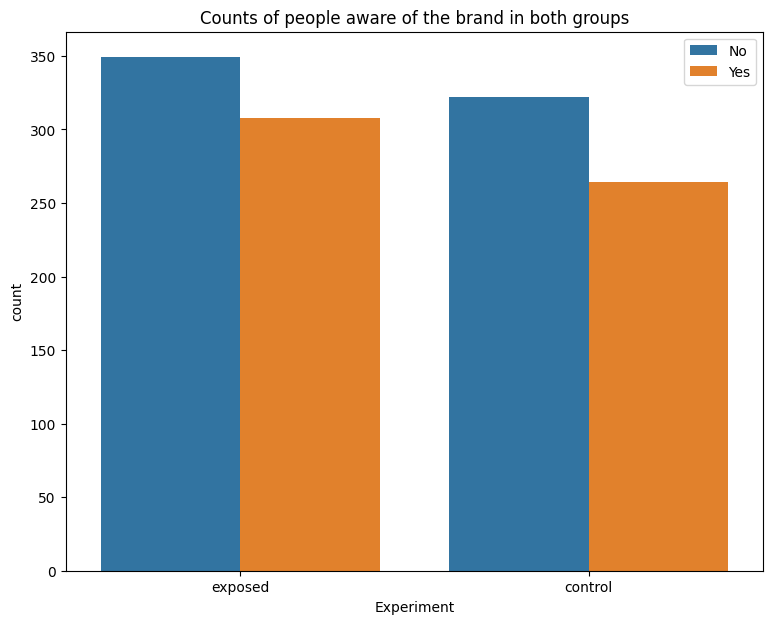

In [6]:
# Counting the people that are aware of the brand in both groups
plt.figure(figsize=(9,7))
axis = sns.countplot(x='experiment', hue='yes', data=df)
axis.set_xlabel('Experiment')
axis.set_ylabel('count')
axis.set_title('Counts of people aware of the brand in both groups')
plt.legend(['No', 'Yes'])


Text(0.5, 1.0, 'Count of Browsers used by the participants')

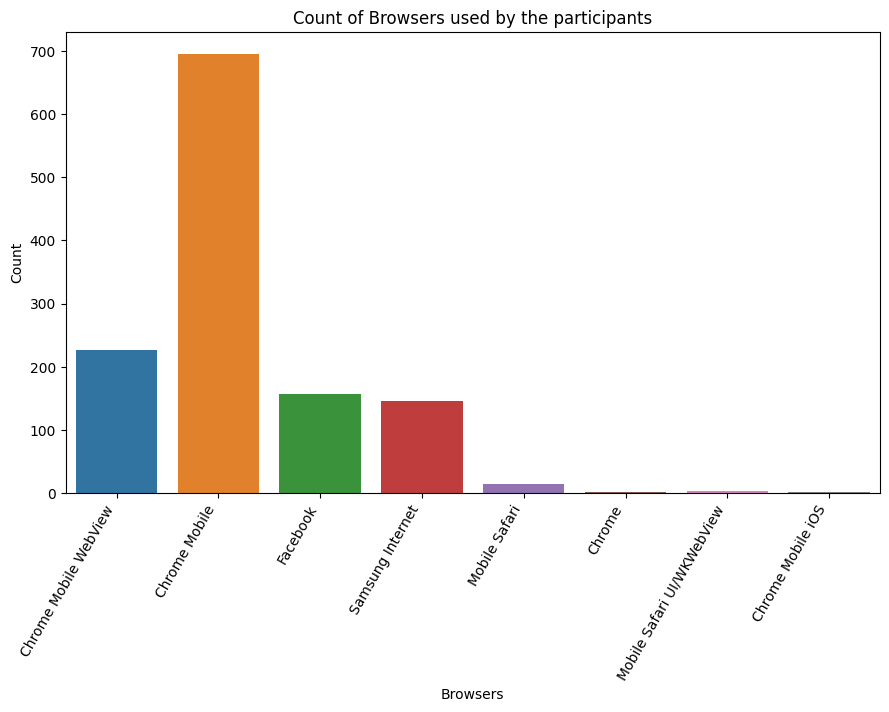

In [7]:
# Count plot of browsrs
plt.figure(figsize=(9,7))
axis = sns.countplot(x='browser', data=df)
axis.set_xticklabels(axis.get_xticklabels(), rotation=60, ha='right')
plt.tight_layout()
axis.set_xlabel('Browsers')
axis.set_ylabel('Count')
axis.set_title('Count of Browsers used by the participants')


Text(0.5, 1.0, 'Distribution fo Hour')

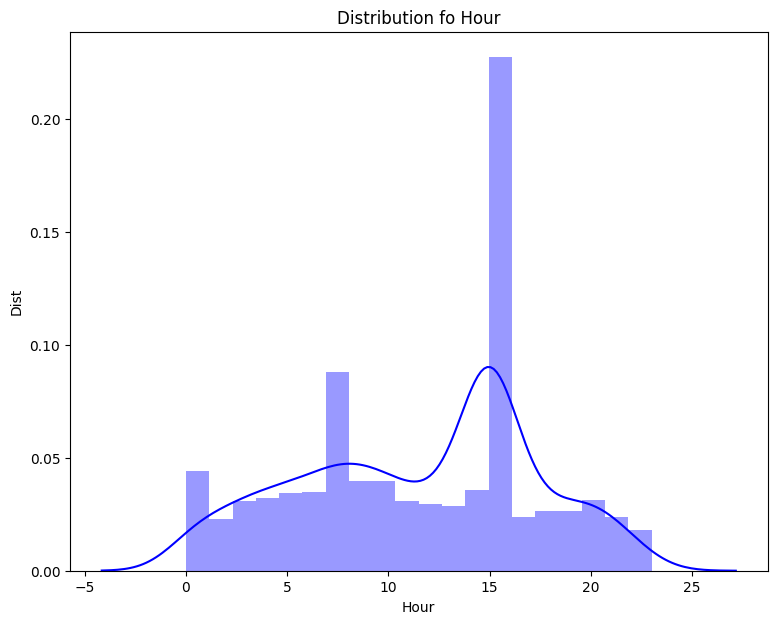

In [8]:
# Distribution of Hour
plt.figure(figsize=(9,7))
axis = sns.distplot(df['hour'],bins=20, color='blue')
axis.set_xlabel('Hour')
axis.set_ylabel('Dist')
#axis.title('Distribution fo Hour')
plt.title('Distribution fo Hour')


findfont: Font family ['bold'] not found. Falling back to DejaVu Sans.


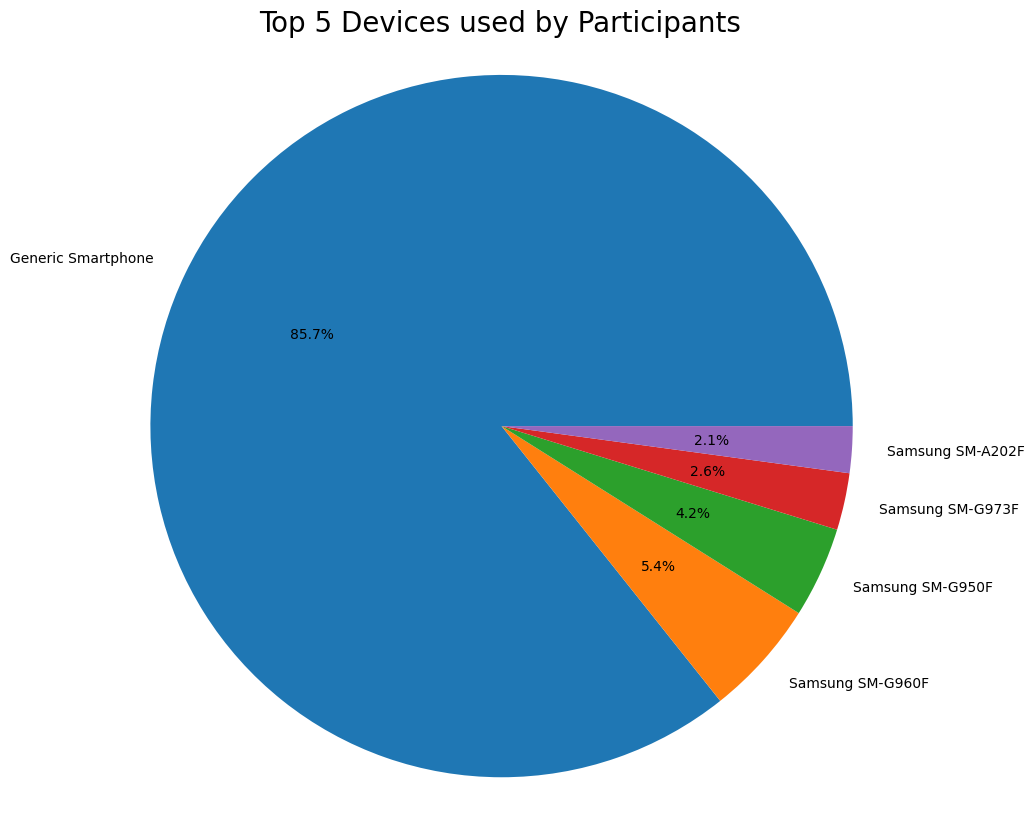

In [9]:
# Top 5 Devices
t5_device = df['device_make'].value_counts().nlargest(5)
fig1,ax1 = plt.subplots(figsize=(10,10))
ax1.pie(t5_device.values, labels=t5_device.index, autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title('Top 5 Devices used by Participants', font='bold',fontsize=20)
plt.show()

In [12]:
# the number of aware people vs the total people
exposed_yes = df.query('experiment == "exposed"').yes
exposed_count = len(exposed_yes)
exposed_yes_count = exposed_yes.sum(axis=0)

control_yes = df.query('experiment == "control"').yes
control_count = len(control_yes)
control_yes_count = control_yes.sum(axis=0)
print('Control yes count:',control_yes_count,'    Total Control:',control_count)
print('Exposed yes count:',exposed_yes_count,'    Total Exposed:',exposed_count)

Control yes count: 264     Total Control: 586
Exposed yes count: 308     Total Exposed: 657


In [13]:
import statsmodels.stats.api as sms
# Determine the required sample size and check if we have sufficent sample size 
baseline_rate = control_yes_count / control_count
practical_significance = 0.01  # minimum required effect size
confidence_level = 0.05 
sensitivity = 0.8 

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  38932  per group


We can see we don't have the required sample size as we only have 586 and 657 in the total control and total exposed group respectively

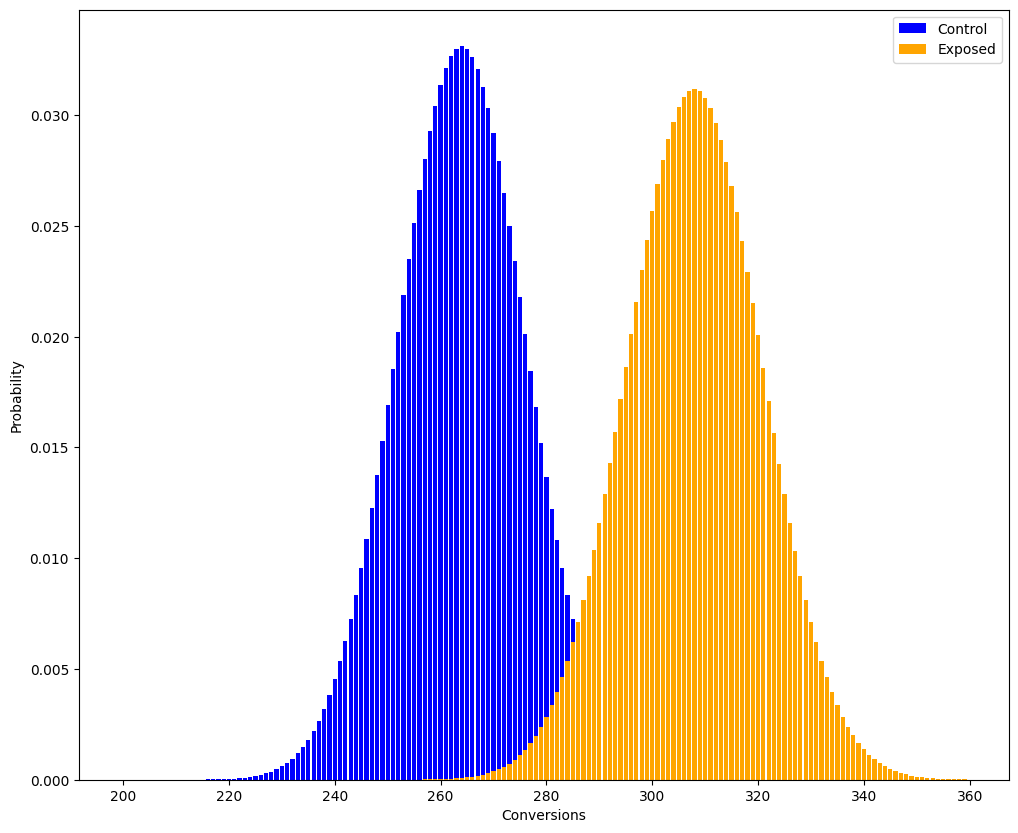

In [14]:
from scipy.stats import binom
# Calculate the Conversions for each group
cv_rate_control, cv_rate_exposed = control_yes_count / control_count, exposed_yes_count / exposed_count
range = np.arange(200, 360)
cv_prob_control = binom(control_count, cv_rate_control).pmf(range)
cv_prob_exposed = binom(exposed_count, cv_rate_exposed).pmf(range)
fig, ax = plt.subplots(figsize=(12,10))
plt.bar(range, cv_prob_control, label="Control",color='blue')
plt.bar(range, cv_prob_exposed, label="Exposed",color='orange')
plt.legend()
plt.xlabel("Conversions"); plt.ylabel("Probability");

#### This shows the exposed group has an edge in conversion. i.e the controlled group converted more then the exposed group. 
* Which still doesn't mean the experiment was a success. We can also see the peak of the Exposed group is lower than the control group. But we should focus on the conversion rate so we have an applees to apples comparison. 

### Calculate the standard deviation for each experiment group.
This will allow us to change our binomial distribution to normal distribution and calculate Z-scores

In [15]:
std_control = np.sqrt(cv_rate_control * (1 - cv_rate_control) / control_count)
std_exposed = np.sqrt(cv_rate_exposed * (1 - cv_rate_exposed) / exposed_count)

SE_control = np.sqrt(cv_rate_control * (1-cv_rate_control)) / np.sqrt(control_count)
SE_exposed = np.sqrt(cv_rate_exposed * (1-cv_rate_exposed)) / np.sqrt(exposed_count)
print(std_control, SE_control)

0.02055339057798332 0.02055339057798332


### Calculate the conversion rates for the experiment groups and plot the probabilit distribution

Text(0, 0.5, 'Probability')

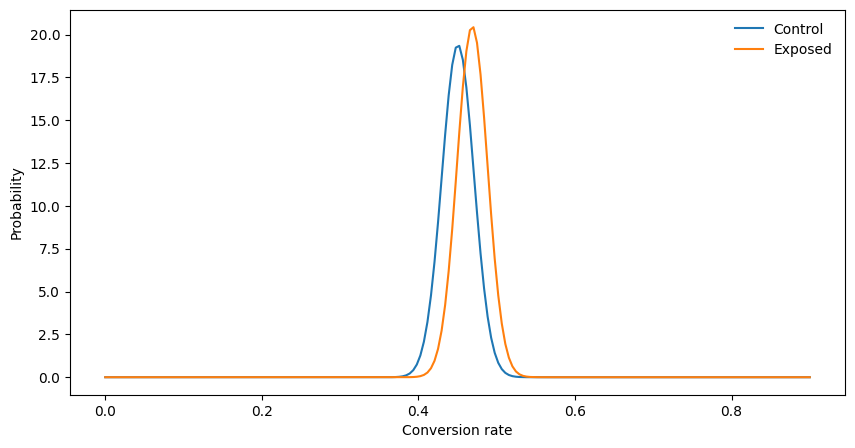

In [16]:
from scipy.stats import norm
conversion_rate = np.linspace(0, 0.9, 200)
prob_a = norm(cv_rate_control, SE_control).pdf(conversion_rate)
prob_b = norm(cv_rate_exposed, SE_exposed).pdf(conversion_rate)
plt.figure(figsize=(10,5))
plt.plot(conversion_rate, prob_a, label="Control")
plt.plot(conversion_rate, prob_b, label="Exposed")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability")

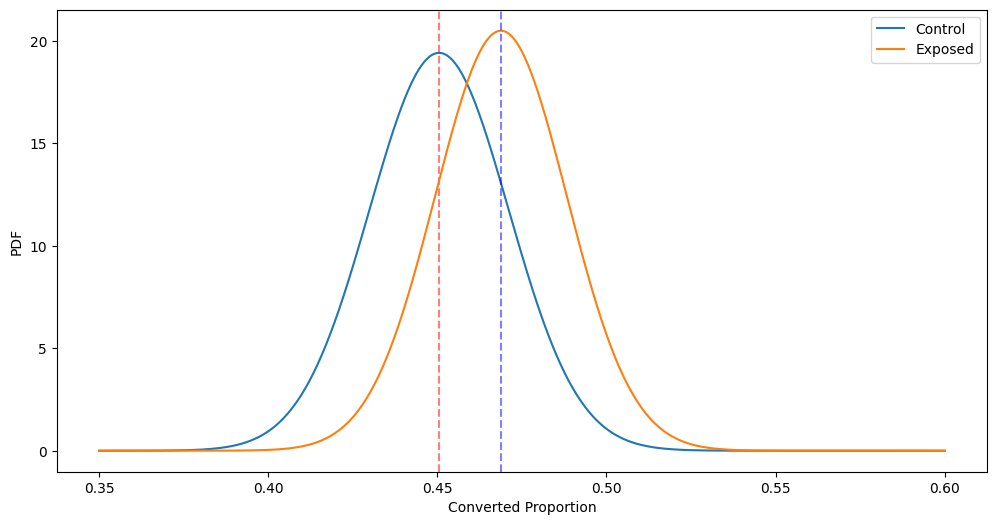

In [17]:
import scipy.stats as scs

fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(cv_rate_control, SE_control).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=cv_rate_control, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(cv_rate_exposed, SE_exposed).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=cv_rate_exposed, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Converted Proportion') # conversion rate
plt.ylabel('PDF') # probability density function
plt.show()

We can also see here the exposed group has an edge! 
* The dash lines represent the mean conversion rate for the both experiment groups

Calculate variance

In [18]:
#calculate variance of sum
var_cont = np.sqrt(cv_rate_control * (1 - cv_rate_control) / control_count)
var_exp = np.sqrt(cv_rate_exposed * (1 - cv_rate_exposed) / exposed_count)
var_cont, var_exp

(0.02055339057798332, 0.019468837373132736)

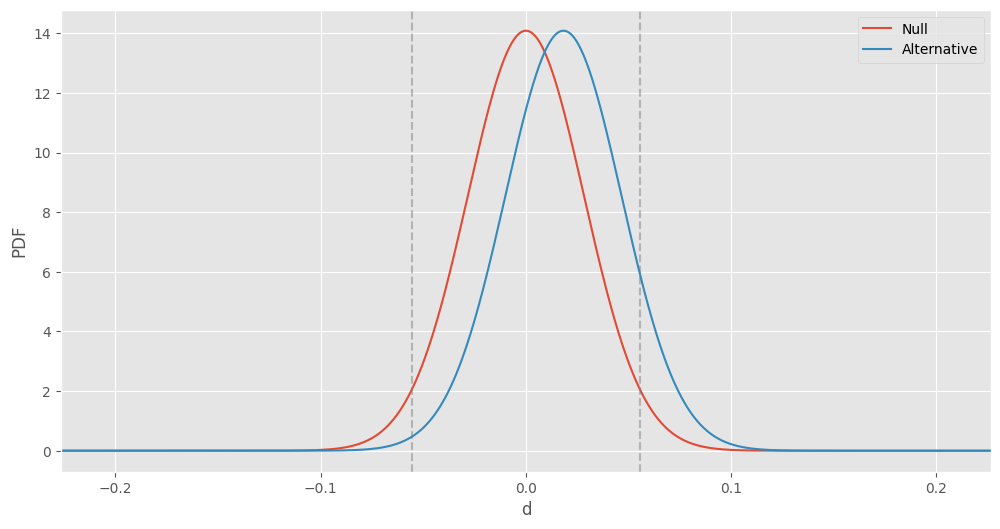

In [19]:
import hypo_plots
diff = cv_rate_exposed - cv_rate_control
hypo_plots.abplot(control_count, exposed_count, cv_rate_control, diff)

* The Alternative hypothesis exposed group has higher conversion rate than the control grouo 

### Calculate the p-value and Z-score

In [20]:
diff = cv_rate_exposed - cv_rate_control
z_score = (diff) / np.sqrt(var_cont**2 + var_exp**2)
print(f"zscore is {z_score:0.5f}, with p-value {scs.norm().sf(z_score):0.5f}")

zscore is 0.64590, with p-value 0.25917


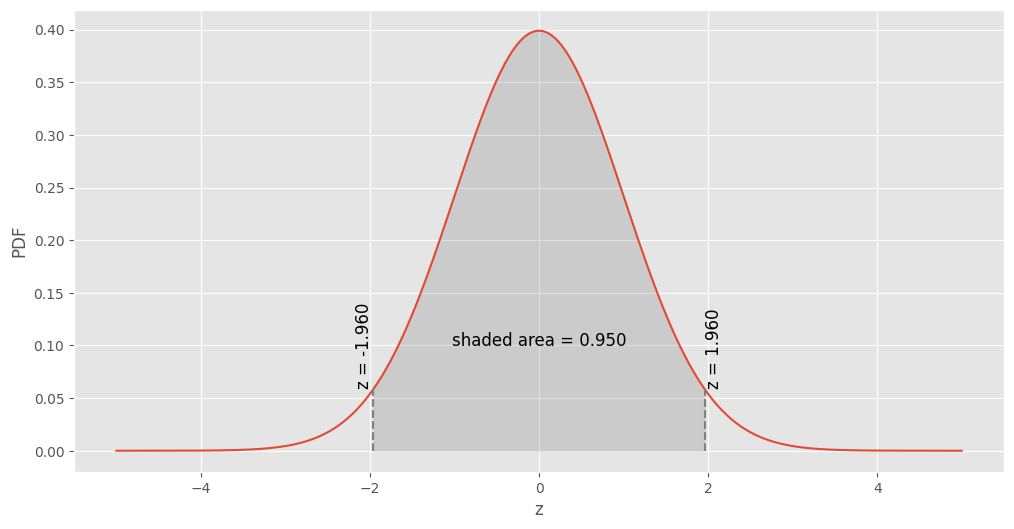

In [21]:
hypo_plots.zplot(area=0.95)

* The p-value, or probability value, tells you how likely it is that your data could have occurred under the null hypothesis.
* if the null hypothesis is assuemed to be true, the p-value gives us an estimate of how strange our sample is
* if the p-value is very small(<0.05) then we are likely to reject the null hypothesis.

* But in our case the p-value is 0.259 greater than 0.05(significance level).
* Thus, we can't reject the null hypothesis

Statistical Power plot

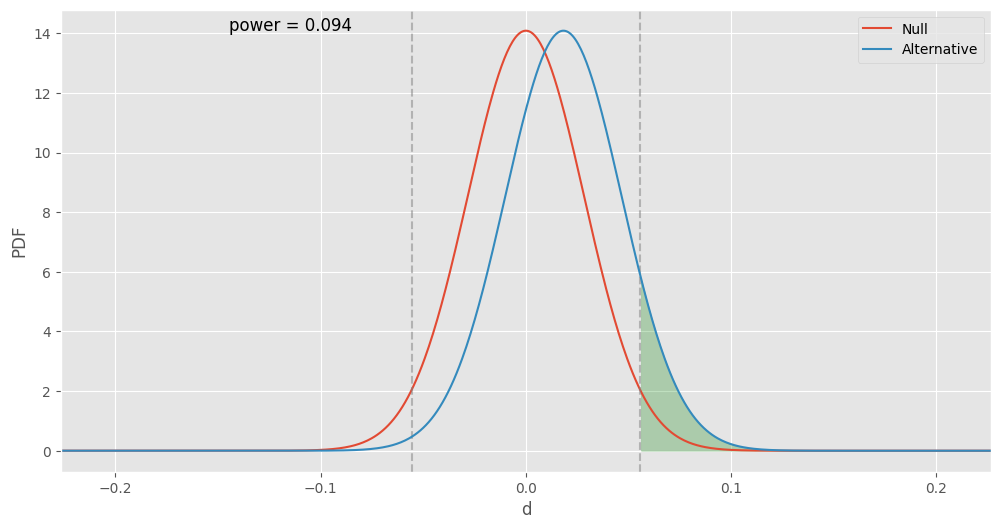

In [25]:
hypo_plots.abplot(control_count, exposed_count, cv_rate_control, diff, show_power=True )

The statistical power of a hypothesis test is the probability of detecting an effect, if there is a true effect present to detect.
* It is calculated by finding the area under the alternative hypothesis and outside of the CI of the null hypothesis.

Confidence Level

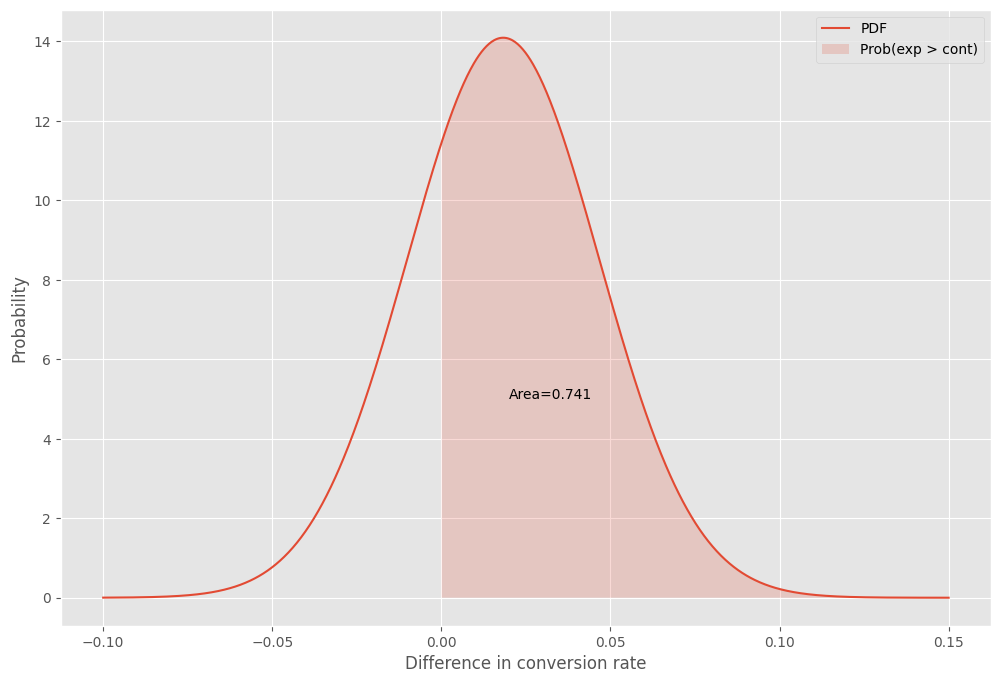

In [27]:
p = scs.norm(diff, np.sqrt(var_cont**2 + var_exp**2))
x = np.linspace(-0.1, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.subplots(figsize=(12, 8))
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x > 0, label="Prob(exp > cont)", alpha=0.2)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate")
plt.ylabel("Probability")
plt.show()

* A confidence interval displays the probability that a parameter will fall between a pair of values around the mean
* The confidence interval is 0.741 i.e the area in the above plot
* It means the exposed group have 74.1% awarness as the controlled one
* For the remaining percent the exposed group have different awareness from the controlled group

Optimal Sample Size

In [28]:
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    standard_norm = scs.norm(0, 1)
    Z_beta = standard_norm.ppf(power)
    Z_alpha = standard_norm.ppf(1-sig_level/2)
    pooled_prob = (bcr + bcr+mde) / 2
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2/ mde**2)
    return min_N

In [29]:
power = 0.8 # power = 80%
sig_level = 0.05
sample_80 = round(min_sample_size(cv_rate_control, diff, power,  sig_level))
print(f'Minimum sample size for 80% statistical power is : {sample_80} ')

Minimum sample size for 80% statistical power is : 11661 


In [30]:
power = 0.9 # power = 90%
sig_level = 0.05
sample_80 = round(min_sample_size(cv_rate_control, diff, power,  sig_level))
print(f'Minimum sample size for statistical 90% power is : {sample_80} ')

Minimum sample size for statistical 90% power is : 15610 


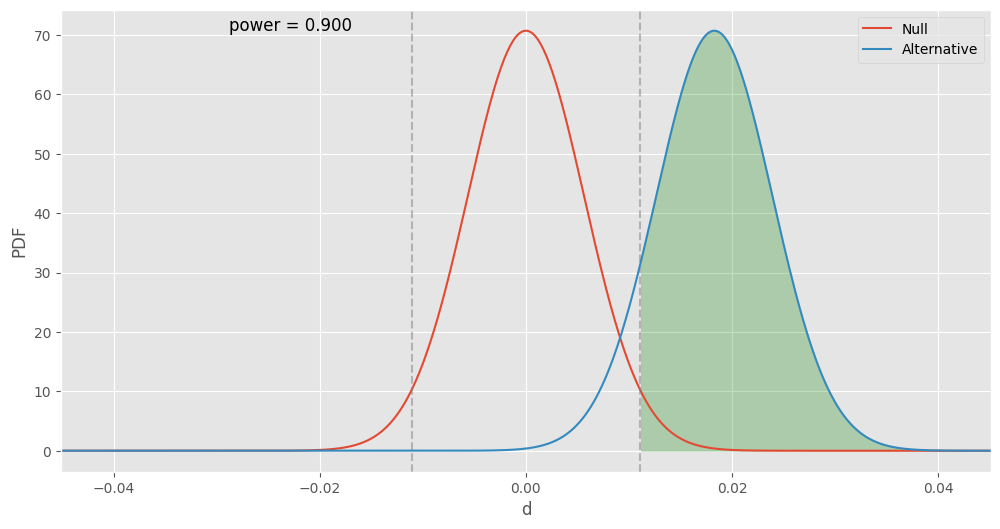

In [32]:
hypo_plots.abplot(sample_80, sample_80, cv_rate_control, diff, show_power=True)

In [34]:
power = 0.8
sig_level = 0.1 # increased the cofidance level to 0.1
sample_80 = round(min_sample_size(cv_rate_control, diff, power,  sig_level))
print(f'Minimum sample size for 80% statistical power is : {sample_80} ')

Minimum sample size for 80% statistical power is : 9185 
